# How to use auto_ab library

In [1]:
import sys, yaml, os, json
import pandas as pd
import numpy as np

sys.path.append(str('../'))
from auto_ab import ABTest, Splitter, VarianceReduction, Graphics

## Loading config file

In [2]:
try:
    project_dir = os.path.dirname(os.path.abspath(''))
    config_file = os.path.join(project_dir, 'config.yaml')
    with open (config_file, 'r') as file:
        config = yaml.safe_load(file)
except yaml.YAMLError as exc:
    print(exc)
    sys.exit(1)
except Exception as e:
    print('Error reading the config file')
    sys.exit(1)

## Loading dataset

In [ ]:
data = pd.read_csv(os.path.join(project_dir, 'data/internal/guide/data.csv'), index_col='id')
data.head()

## Initialization of splitter

If you are going to run MDE simulation, **split_rate** parameter can be omitted.

In [ ]:
splitter = Splitter(split_rate=config['splitter']['split_rate'])

## Initialization of A/B-test

Here
- **alpha** — significance level
- **alternative** — 'less', 'more', 'two-sided'

In [ ]:
ab = ABTest(alpha=config['hypothesis']['alpha'], 
            alternative=config['hypothesis']['alternative'])

### Set loaded dataset as analyzed

In [ ]:
ab.use_dataset(data, id_col=config['data']['id_col'],
              target=config['data']['target'])

### Set previously defined splitter for test

In [ ]:
ab.splitter = splitter

### Set list of split rates for MDE exploration

In [ ]:
ab.split_rates = config['simulation']['split_rates']

### Set list of increments for MDE exploration

Here
- **inc_var** — list of increments, i.e. [1, 2, 3, 4, 5]
- **extra_paramms** — extra parameters for increment, currently not used in analysis

In [ ]:
ab.set_increment(inc_var=config['simulation']['increment']['vars'],
                extra_params=config['simulation']['increment']['extra_params'])

### Create metric which you want to compare

In the example below, we want to compare 10th percentile of control and treatment distributions

In [ ]:
def metric(X: np.array) -> float:
    return np.quantile(X, 0.1)

### MDE simulation in order to find the best combination of split rate—increment

Here
- **n_iter** — number of iterations of simulation
- **n_boot_samples** — set if you choose bootstrap hypothesis testing
- **metric_type** — metric type: ratio or solid (continuous)
- **metric** — Python function as tested metric (quantile, median, mean, etc)
- **strategy** — strategy of hypothesis testing
- **strata** — strata column name for variance reduction
- **strata_weights** — weights of each unique value in strata column as a dictionary
- **to_csv** — whether or not to save the result to csv file
- **csv_path** — path to the newly created csv file

In [ ]:
res = ab.mde_simulation(n_iter=config['simulation']['n_iter'],
                       n_boot_samples=config['hypothesis']['n_boot_samples'],
                       metric_type=config['metric']['metric_type'],
                       metric=metric,
                       strategy=config['hypothesis']['strategy'],
                       strata=config['hypothesis']['strata'],
                       strata_weights=config['hypothesis']['strata_weights'],
                       to_csv=config['result']['to_csv'],
                       csv_path=config['result']['csv_path'])

### Print simulation log

Here
- **first key** — split rate
- **second key** — increment
- **value** — share of rejected H0

In [ ]:
print(json.dumps(res, indent=4))

### Visualize simulation log in plot

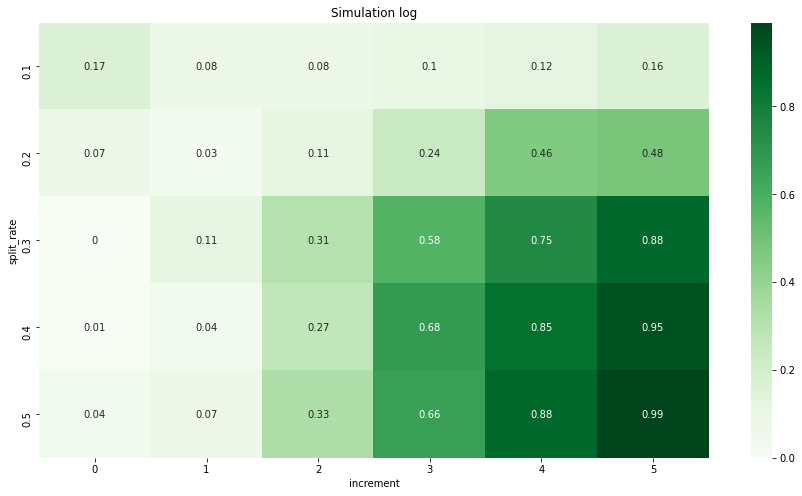

In [3]:
gf = Graphics()
gf.plot_simulation_log(config['result']['csv_path'])

## Perform A/B-test

### Loading dataset generated during A/B-test

Here
- **height_now** — experiment metric during experiment
- **height_prev** — experiment metric before experiment
- **weight_now** — highly correlated feature with metric during experiment
- **weight_prev** — highly correlated feature with metric before experiment
- **noise_now** — feature during experiment that is just noise
- **noise_prev** — feature before experiment that is just noise
- **groups** — groups column

In [4]:
ab_data = pd.read_csv(os.path.join(project_dir, 'data/internal/guide/ab_data.csv'))
ab_data.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B


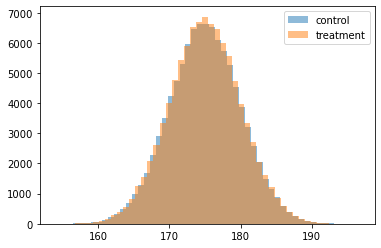

In [10]:
gf.plot_distributions(ab_data, 'height_now', 'groups', 50, '')

### Use CUPED to reduce variance

After the execution, new column is introduced — **height_now_cuped**.

In [15]:
vr = VarianceReduction()
ab_data_cuped = vr.cuped(ab_data, target='height_now', groups='groups', covariate='height_prev')
print(ab_data_cuped.head())

Covariate is column `height_prev`
   height_now  height_prev  weight_now  weight_prev  noise_now  noise_prev  \
0  172.470442   166.382868  163.648256   173.422115   5.644384   -1.923929   
1  178.610565   173.386388  173.195935   180.831845  11.664751    2.711829   
2  180.382301   178.563579  174.520065   181.571024   7.183178   -0.453939   
3  180.954018   179.732080  175.731245   182.840388  -4.682656    6.358723   
4  167.590042   167.684244  166.109779   170.189261   9.134517   -1.153977   

  groups  height_now_cuped  
0      A        177.314721  
1      B        177.420444  
2      A        174.723145  
3      B        174.292002  
4      B        171.316884  


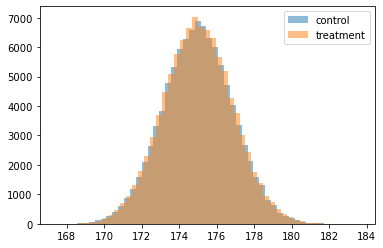

In [16]:
gf.plot_distributions(ab_data_cuped, 'height_now_cuped', 'groups', 50, '')

As can be seen, variance reduced **from 160 to 170** on the left and **from 190 to 180** on the right.

### Use CUPAC to reduce variance

Below you can see the model that was created to predict covariate to experiment period.
After the execution, new column is introduced — **target_pred**.

In [18]:
ab_data_cupac = vr.cupac(ab_data, target_prev='height_prev', target_now='height_now',
               factors_prev=['weight_prev'],
               factors_now=['weight_now'], groups='groups')

                                 OLS Regression Results                                
Dep. Variable:            height_prev   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.198e+09
Date:                Wed, 25 Aug 2021   Prob (F-statistic):                        0.00
Time:                        16:52:06   Log-Likelihood:                     -4.4357e+05
No. Observations:              200000   AIC:                                  8.871e+05
Df Residuals:                  199999   BIC:                                  8.871e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [19]:
print(ab_data_cupac.head())

   height_now  height_prev  weight_now  weight_prev  noise_now  noise_prev  \
0  172.470442   166.382868  163.648256   173.422115   5.644384   -1.923929   
1  178.610565   173.386388  173.195935   180.831845  11.664751    2.711829   
2  180.382301   178.563579  174.520065   181.571024   7.183178   -0.453939   
3  180.954018   179.732080  175.731245   182.840388  -4.682656    6.358723   
4  167.590042   167.684244  166.109779   170.189261   9.134517   -1.153977   

  groups  height_now_cuped  target_pred  
0      A        177.935483   159.033172  
1      B        175.854315   168.311595  
2      A        176.476356   169.598383  
3      B        176.012450   170.775406  
4      B        170.941725   161.425277  


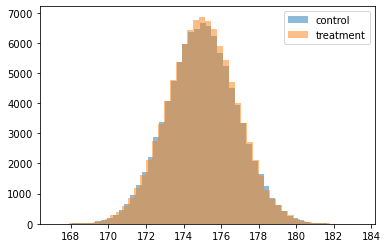

In [20]:
gf.plot_distributions(ab_data_cupac, 'height_now_cuped', 'groups', 50, '')

As can be seen, variance reduced **from 160 to 170** on the left and **from 190 to 180** on the right.